# CTL Project

## Stack Pets

In [1]:
import pandas as pd
import numpy as np
from xml.etree import ElementTree as et
import re
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
%matplotlib inline
pd.set_option('display.max_columns', 1000, 'display.width', 1000, 'display.max_rows',1000, 'max_colwidth', 1000)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/Users/joshuamalina/.conda/envs/charly/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [3]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

/Users/joshuamalina/.conda/envs/charly/lib/python3.9/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [4]:
path = '/Users/joshuamalina/Documents/projects/ctl_hw/Posts.xml'

In [5]:
tree = et.parse(path)
root = tree.getroot()

In [6]:
!head -n 3 $path

In [7]:
for node in root:
    text = node.attrib['Body']
    break

In [8]:
keys = node.keys()
keys[:3]

['Id', 'PostTypeId', 'AcceptedAnswerId']

In [9]:
data = {}
counter = 0
for node in root:
    post = {k: node.attrib[k] for k in node.keys() if k not in ['Id']}
    data[node.attrib['Id']] = post
    if counter % 1000 == 0:
        print(counter)
    counter += 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


In [10]:
df = pd.DataFrame(data).T
df.head()

,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ContentLicense,LastEditorUserId,ClosedDate,ParentId,OwnerDisplayName,CommunityOwnedDate
1,1,58,2013-10-08T21:29:51.963,48,13127,"<p>I have a 2.5 year old pitbull/boxer mix. He is a rescue dog, and is extremely aggressive towards other dogs (and I will probably be asking many questions about that). However, he has always been very good with people, especially women and children. He gets along great with my nephews and my sisters.</p>\n\n<p>A few weeks ago, however, he was diagnosed with heartworm. He has not yet received his first immiticide injection, but he is being kept relatively ""quiet"" under vet's orders. </p>\n\n<p>This seems to have made him more aggressive. He is now - seemingly randomly - lunging at people and bikes when we're out on walks. Just today, a young girl (roughly 10 years of age) was walking by us on the sidewalk, and he lunged at her. I kept him on a short leash, and when he tried to jump again, I pushed him (rather forcefully, I admit) in the chest, knocking him over.</p>\n\n<p>I don't condone violence against animals, but I was angry he would be so aggressive towards a young chi...",3,user9,2013-10-30T19:36:21.243,2021-06-10T17:59:06.283,What causes a dog to lunge at an unknown child and how should the owner respond?,<dogs><behavior><aggression>,4,1,5,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN
2,1,25,2013-10-08T21:40:34.497,22,4242,"<p>I have a miniature dachshund puppy (10 months, 9lbs.) that is easily frightened by loud noises, such as trucks passing by. Walking in any urban setting seems to be a negative experience, but she enjoys walking in secluded areas, such as state parks, that are away from roads.</p>\n\n<p>She also shows fear when there are loud noises at home, such as watching a movie at home. The volume is not turned up to an extreme level. I realize dogs have significantly better hearing than humans, but other dogs I have been around do not exhibit this trait.</p>\n\n<p>I live in a very urban area, so it is not always convenient to exercise my pooch in a secluded park area. Is there a simple method for overcoming this fear? It is to the point that she runs away when I get the leash, even when offering treats at the same time.</p>\n\n<p>I got her from a respected breeder and she has not experienced any trauma in her short life that I am aware of.</p>\n",10,NaN,2013-10-09T18:18:40.067,2013-10-29T14:27:20.483,How do I walk a small dog afraid of loud noises in an urban area?,<dogs><training><fear><sound>,5,1,NaN,CC BY-SA 3.0,129,NaN,NaN,NaN,NaN
3,1,46,2013-10-08T21:44:30.850,25,12028,<p>I have heard that rabbits make good pets. How hard is it house break rabbits? </p>\n,13,user87,2013-11-08T05:17:26.077,2015-04-12T12:53:57.803,What is required to house break a rabbit?,<rabbits><toilet-training>,4,0,3,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN
4,1,13,2013-10-08T22:00:00.877,9,421,"<p>My friend's dog uses the restroom on his carpet a lot, and he's already tried lots of methods to get it to stop. Does anyone know an effective way to toilet train a puppy?</p>\n",22,user87,2018-10-21T02:48:44.107,2018-10-21T02:48:44.107,What is the best way to toilet train a puppy?,<dogs><toilet-training>,2,5,1,CC BY-SA 3.0,22,2013-10-13T14:57:17.440,NaN,NaN,NaN
5,2,NaN,2013-10-08T22:00:43.917,12,NaN,"<p>In my experience rabbits are very easy to housebreak. They like to pee and poop in the same place every time, so in most cases all you have to do is put a little bit of their waste in the litter box and they will happily use the litter box. It is very important that if they go somewhere else, miss the edge or kick waste out of the box that you clean it up well and immediately as otherwise those spots will become existing places to pee and poop. When you clean the box, save a little bit of waste and put it in the cleaned box so it smells right to them.</p>\n\n<p

In [11]:
df.columns

Index(['PostTypeId', 'AcceptedAnswerId', 'CreationDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId', 'LastEditorDisplayName', 'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount', 'FavoriteCount', 'ContentLicense', 'LastEditorUserId', 'ClosedDate', 'ParentId', 'OwnerDisplayName', 'CommunityOwnedDate'], dtype='object')

In [12]:
df['OwnerDisplayName'].dropna().unique()

array(['user34', 'user35', 'user43', 'user6796', 'user9', 'user194',
       'user237', 'user347', 'anon', 'user694', 'user907', 'glenviewjeff',
       'user1064', 'user1256', 'user2477', 'user2505', 'kare', 'user2680',
       'user2806', 'user2863', 'user2801', 'OldCurmudgeon', 'AndrewG',
       'fubar50', 'user2579', 'user3369', 'user3384', 'user3431',
       'user5055', 'SmartestVEGA', 'Ching Chong', 'Mooseman', 'sasquatch',
       'holroy', 'user5479', 'user5520', 'Yorrick', 'Yvonne Liew',
       'user5807', 'user5899', 'user6034', 'Rod Maniego', 'Escoce',
       'user6866', 'user6917', 'DevilApple227', 'descheleschilder',
       'Jeff Meigs', 'Taren Suarez', 'Jim Thio', 'user8045', 'user8524',
       'Dogmal', 'user8659', 'user8868', 'susan', 'user9091', 'user9314',
       'user8150', 'user9424', 'user9836', 'user9803', 'user10093',
       'user10732', 'user10848', 'Hunter Graham', 'lkessler', 'user39244',
       'Sherwood Botsford', 'Alex', 'user11856', 'kryomaxim', 'user11804',
 

In [13]:
df.shape

(19533, 21)

In [14]:
df[['OwnerUserId', 'OwnerDisplayName']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 19533 entries, 1 to 32853
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   OwnerUserId       18802 non-null  object
 1   OwnerDisplayName  752 non-null    object
dtypes: object(2)
memory usage: 457.8+ KB


In [15]:
def isOneToOne(df, col1, col2):
    first = df.drop_duplicates([col1, col2]).groupby(col1)[col2].count().max()
    second = df.drop_duplicates([col1, col2]).groupby(col2)[col1].count().max()
    return first + second == 2

## Exploratory Data Analysis

User6796 spends a lot of time here ...

<AxesSubplot:>

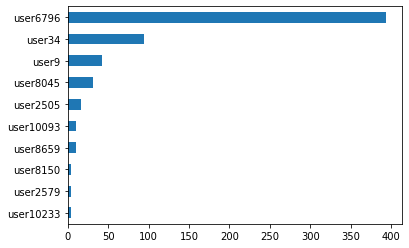

In [16]:
df['OwnerDisplayName'].dropna().value_counts().head(10).sort_values().plot.barh()

What does this person talk about?

In [17]:
df[df['OwnerDisplayName'] == 'user6796'][['Title']].dropna()

,Title
134,What is the optimal age to neuter a male dog?
135,"How much to feed outdoor goldfish, that feed on insects?"
136,How should I trim the wings of my bird?
145,"How can I safely leave my 3 pets overnight, unsupervised?"
147,Do my horses need to be shod?
165,How would I socialise my puppy with other animals and people?
166,Is hand feeding my horses hay enough to supplement their feed if my grass is not enough to sustain them?
181,How can I prevent my dog from chasing his tail obsessively?
191,Abscess in horses hoof
193,Severe separation anxiety in dog


Nevermind! Stack Exchange does not enforce unique "OwnerDisplayNames"! 

[https://meta.stackexchange.com/questions/25404/why-does-stack-overflow-allow-duplicate-display-names]

<AxesSubplot:>

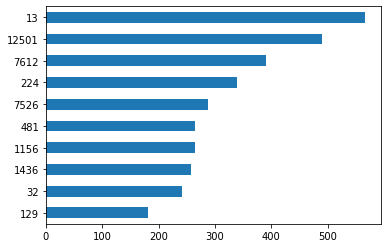

In [18]:
df['OwnerUserId'].dropna().value_counts().head(10).sort_values().plot.barh()

From a brief amount of internet research, "OwnerUserId" is, in fact, unique. So OwnerUserID 13 should identify a real person. Let's see what they are in to!

In [19]:
df[df['OwnerUserId'] == '13'][['Title']].dropna()

,Title
3,What is required to house break a rabbit?
358,Why do rabbits chew electrical wires?
514,What means do rabbits use to mark and defend their territory?
551,Why is adding hay to a rabbit's diet important?
617,Do bunnies eat their droppings?
650,Is dry food better for pets’ teeth?
1149,"Do fish get bored, and if so, how can fish boredom be identified?"
1157,Should I worry that my rabbit is leaving connected poops?
1214,Are rabbits really the third most popular pet?
1310,How can I train my rabbit to use the toilet?


### Rabbits!

In [20]:
user13 = df[df['OwnerUserId'] == '13']

In [21]:
user13.Title.dropna().apply(lambda x: 'rabbit' in x or 'rabbits' in x).value_counts(normalize=True).mul(100)

False    62.886598
True     37.113402
Name: Title, dtype: float64

### User13 really likes rabbits. 37% of their 566 posts mention rabbit or rabbits. A few gems:

"Can rabbits make babies when separated by a single wire cage wall?"

"Do rabbits fight each other to the death?"

"How can I train my rabbit to use the toilet?"

"What would make a rabbit herd sheep?"

## Let's find out if User13 is a rabbit outlier

In [22]:
# https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
dummies = pd.get_dummies(df.set_index('OwnerUserId')['Tags'].dropna().apply(lambda x: sorted(x[1:-1].split('><'))).apply(pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)
dummies.head()

,acclimation,adoption,age,aggression,agility,algae,allergies,amphibians,anatomy,animal-handling,anxiety,aquarium,aquatic-plants,arachnids,arthritis,attire,autotomy,bathing,bearded-dragon,bedding,behavior,betta,big-cats,biology,birds,biting,boarding,bonding,breeding,breeds,budgerigar,burmese,cage,can-food,cancer,cat-food,cat-litter,catio,cats,cecotropes,certificate,chameleons,chewing,chickens,children,chinchillas,cichlid,cites,cleaning,clicker-training,clownfish,cockatiels,cocker-spaniel,collar,communication,community-aquarium,community-faq,compatibility,competitions,containment,cooked-food,cooling,cows,crate,crickets,crossbreed,dachshunds,danio,death,defecation,dental-care,desexing,diabetes,diet,digestion,digging,disability,disaster,diseases,docking,dogs,domestication,dominance,donkeys,drinking,ducks,eating,eggs,emergency,enclosure,equestrian,equipment,euthanasia,excretions,exercise,exotic-pets,eye-disease,farm-animals,fear,feeding,feral,ferrets,filters,first-aid,fish,fleas,fostering,freshwater,frogs,fundraising,geckos,gender-differentiation,genetics,gerbil,goats,goldfish,grooming,growing,guinea-pigs,guppies,habitat,hairloss,hamsters,health,hearing,heart-health,heaters,hermit-crabs,history,horses,house-moving,identification,infections,injury,insects,introducing-pets,invertebrates,junior-pets,koi,large-dogs,leash-training,legal,leopard-geckos,lighting,lizards,lost-pet,maintenance,marking,medicines,mental-stimulation,mice,molting,multi-pet-families,neutering,outdoor,parasites,parrots,pest-control,pet-selection,pig,pregnancy,psychology,purebred,rabbits,rat,reactivity,reproduction,reptiles,rodents,safety,saltwater,senior-pet,shelter,snails,snakes,socializing,strays,surgery,terminology,territory,ticks,toilet-training,tortoises,training,travel,turtles,urination,vaccination,veterinarian,vocalizations,winter,brineshrimp,claws,decorations,ears-nose-throat,ethics,farriers,feces,fetch,fox,furniture,genet,german-shepherd,gps,guinea-fowls,hedgehog,herbivore,herding,humane-society,hunting,husky,hygiene,instinct,insurance,leashes,lifespan,literature,live-food,maine-coon,new-medicine,new-pets,pain,pet-names,physiology,plants,play,poison,pond,puppy,recall,reef-tank,scratching,sea-monkeys,separation-anxiety,service-animal,shedding,skin-condition,skinny-pigs,sleep,snoring,sound,sports,stress,substrate,swimming,teething,temperature,terrariums,tests,tetra,toys,treats,united-states,upper-respiratory-disease,urinary-tract-disease,vision,water-changes,water-parameters,weather,weight,weight-loss,wound-care,clown-plecos,coughing,fire,gourami,imidacloprid,liver-disease,mutts,pleco,public-health,salamanders,sample-collection,scorpions,sheep,shrimp,sight,supplements,tarantulas,trancing,uk,vegetarian-food,weaning,welsh-collie,whippet,hitting,llamas,pigeon,saddle,sturgeons,ttouch
OwnerUserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

<AxesSubplot:title={'center':'Percentage of Posts By Tag'}>

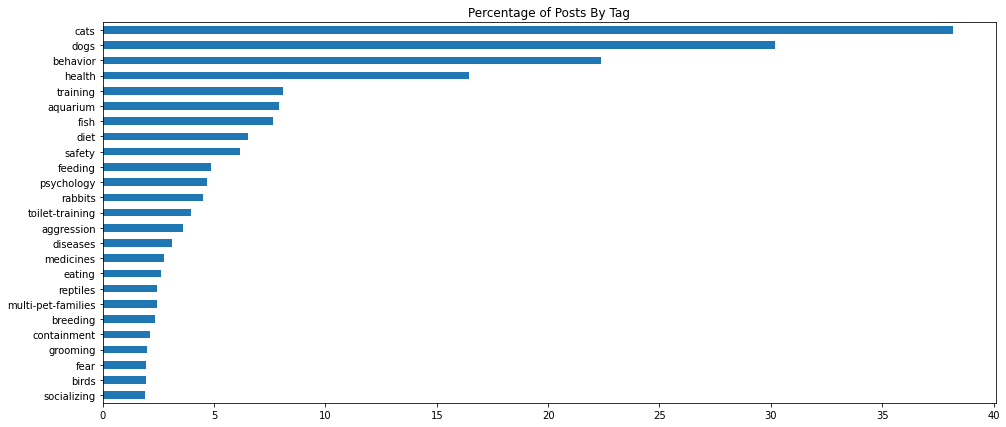

In [23]:
dummies.describe().loc['mean'].sort_values(ascending=False).mul(100).head(25).sort_values().plot.barh(title='Percentage of Posts By Tag', figsize=(16,7))

In [24]:
dummies.loc['13'].describe().loc['mean'].sort_values(ascending=False).head()

rabbits    0.453608
health     0.273196
cats       0.159794
diet       0.123711
safety     0.097938
Name: mean, dtype: float64

We can see that the "rabbits" tag applies to about 5% of posts, whereas for User 13, they write about 45% of their posts about rabbits.

Of course, this is not so incredible. Most stack users probably overwhelmingly post about a small set of animals that they own and care for.

<!-- This could be an interesting line of inquiry -- how many animals, on average, does a user write about? -->

In [25]:
#dummies.head(10).groupby(level=0).mean()

## Fear

What is this tag all about?

In [26]:
# https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
dummies_og_index = pd.get_dummies(df['Tags'].dropna().apply(lambda x: sorted(x[1:-1].split('><'))).apply(pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)
dummies_og_index.head()

,acclimation,adoption,age,aggression,agility,algae,allergies,amphibians,anatomy,animal-handling,anxiety,aquarium,aquatic-plants,arachnids,arthritis,attire,autotomy,bathing,bearded-dragon,bedding,behavior,betta,big-cats,biology,birds,biting,boarding,bonding,breeding,breeds,budgerigar,burmese,cage,can-food,cancer,cat-food,cat-litter,catio,cats,cecotropes,certificate,chameleons,chewing,chickens,children,chinchillas,cichlid,cites,cleaning,clicker-training,clownfish,cockatiels,cocker-spaniel,collar,communication,community-aquarium,community-faq,compatibility,competitions,containment,cooked-food,cooling,cows,crate,crickets,crossbreed,dachshunds,danio,death,defecation,dental-care,desexing,diabetes,diet,digestion,digging,disability,disaster,diseases,docking,dogs,domestication,dominance,donkeys,drinking,ducks,eating,eggs,emergency,enclosure,equestrian,equipment,euthanasia,excretions,exercise,exotic-pets,eye-disease,farm-animals,fear,feeding,feral,ferrets,filters,first-aid,fish,fleas,fostering,freshwater,frogs,fundraising,geckos,gender-differentiation,genetics,gerbil,goats,goldfish,grooming,growing,guinea-pigs,guppies,habitat,hairloss,hamsters,health,hearing,heart-health,heaters,hermit-crabs,history,horses,house-moving,identification,infections,injury,insects,introducing-pets,invertebrates,junior-pets,koi,large-dogs,leash-training,legal,leopard-geckos,lighting,lizards,lost-pet,maintenance,marking,medicines,mental-stimulation,mice,molting,multi-pet-families,neutering,outdoor,parasites,parrots,pest-control,pet-selection,pig,pregnancy,psychology,purebred,rabbits,rat,reactivity,reproduction,reptiles,rodents,safety,saltwater,senior-pet,shelter,snails,snakes,socializing,strays,surgery,terminology,territory,ticks,toilet-training,tortoises,training,travel,turtles,urination,vaccination,veterinarian,vocalizations,winter,brineshrimp,claws,decorations,ears-nose-throat,ethics,farriers,feces,fetch,fox,furniture,genet,german-shepherd,gps,guinea-fowls,hedgehog,herbivore,herding,humane-society,hunting,husky,hygiene,instinct,insurance,leashes,lifespan,literature,live-food,maine-coon,new-medicine,new-pets,pain,pet-names,physiology,plants,play,poison,pond,puppy,recall,reef-tank,scratching,sea-monkeys,separation-anxiety,service-animal,shedding,skin-condition,skinny-pigs,sleep,snoring,sound,sports,stress,substrate,swimming,teething,temperature,terrariums,tests,tetra,toys,treats,united-states,upper-respiratory-disease,urinary-tract-disease,vision,water-changes,water-parameters,weather,weight,weight-loss,wound-care,clown-plecos,coughing,fire,gourami,imidacloprid,liver-disease,mutts,pleco,public-health,salamanders,sample-collection,scorpions,sheep,shrimp,sight,supplements,tarantulas,trancing,uk,vegetarian-food,weaning,welsh-collie,whippet,hitting,llamas,pigeon,saddle,sturgeons,ttouch
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [27]:
fear_indices = dummies_og_index[dummies_og_index['fear'] == 1].index
fear_indices[:2]

Index(['2', '387'], dtype='object')

In [28]:
fear_data = df.loc[fear_indices]
fear_data.head()

,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ContentLicense,LastEditorUserId,ClosedDate,ParentId,OwnerDisplayName,CommunityOwnedDate
2,1,25,2013-10-08T21:40:34.497,22,4242,"<p>I have a miniature dachshund puppy (10 months, 9lbs.) that is easily frightened by loud noises, such as trucks passing by. Walking in any urban setting seems to be a negative experience, but she enjoys walking in secluded areas, such as state parks, that are away from roads.</p>\n\n<p>She also shows fear when there are loud noises at home, such as watching a movie at home. The volume is not turned up to an extreme level. I realize dogs have significantly better hearing than humans, but other dogs I have been around do not exhibit this trait.</p>\n\n<p>I live in a very urban area, so it is not always convenient to exercise my pooch in a secluded park area. Is there a simple method for overcoming this fear? It is to the point that she runs away when I get the leash, even when offering treats at the same time.</p>\n\n<p>I got her from a respected breeder and she has not experienced any trauma in her short life that I am aware of.</p>\n",10,NaN,2013-10-09T18:18:40.067,2013-10-29T14:27:20.483,How do I walk a small dog afraid of loud noises in an urban area?,<dogs><training><fear><sound>,5,1,NaN,CC BY-SA 3.0,129,NaN,NaN,NaN,NaN
387,1,412,2013-10-10T05:24:41.227,19,20371,"<p>My dog, Rex, is like two dogs in one. He is 2.5 years old, neutered pitbull/boxer mix, and is incredibly aggressive towards other dogs.</p>\n\n<p>In the house, he is cuddly, playful, and docile. My mom describes him as ""a big mush"". He gets along with my nieces and nephews, and doesn't even bark [save the rare occasion someone walks down my driveway that he doesn't know].</p>\n\n<p>Outside, totally different story. He walks with almost his entire weight over his front paws; he has his ears up and tail stiff (actually it's hard to tell because his tail is broken); and he will lunge at basically any moving object we come across [I actually don't know what triggers this behavior; I have <a href=""https://pets.stackexchange.com/questions/1/what-causes-a-dog-to-lunge-at-an-unknown-child-and-how-should-the-owner-respond"">another question</a> about something similar]. He pulls on the leash, and essentially refuses to walk anywhere except in front of me. He smells and urinates on eve...",3,user34,2020-05-30T12:44:36.057,2021-04-28T14:15:17.893,Why does my dog act differently outside the house?,<dogs><behavior><fear><stress>,4,7,1,CC BY-SA 4.0,17671,NaN,NaN,NaN,NaN
533,1,2205,2013-10-11T19:25:33.350,15,10793,"<p>My 10-year-old mixed dog has developed quite the arcane fear, she fears power outages.</p>\n\n<p>Whether it happens when it's dark (when all of the lights turn off at the same time), or during the day (in which case, the sound of the wireless phone losing signal from the dock station gives it away), she would start shaking, tail between her legs, come to us for protection.</p>\n\n<p>Now my dog is a burly dog, she stood her ground against dogs several times her size, she can take on anything and doesn't seem to be afraid of anything (loud bangs, fireworks, even a recent war with alarms and rocket whistles and explosions), nothing except for this.</p>\n\n<p>None of us (the family members) are behaving nervously during an outage, and it seemed to just happen to her one day.</p>\n\n<p>What could the cause be, how can I even begin to diagnose it, I hate seeing her like this.</p>\n",161,NaN,2013-10-11T19:32:21.113,2020-05-15T15:44:41.437,What could cause my dog to fear power outages?,<dogs><fear>,4,10,1,CC BY-SA 3.0,161,NaN,NaN,NaN,NaN
1314,1,NaN,2013-11-08T18:00:31.017,9,323,"<p>My new chicken was formerly living with my uncle before I adopted him. According to what my uncle told me, the chicken once experienced another chicken being killed with a knife. Since the

## Topics

Let's see if we can figure out what different animals are scared of. Hopefully we have enough data for these categories.

Let's do:

- dogs
- cats
- fish
- rabbits

In [29]:
fear_data

,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ContentLicense,LastEditorUserId,ClosedDate,ParentId,OwnerDisplayName,CommunityOwnedDate
2,1,25,2013-10-08T21:40:34.497,22,4242,"<p>I have a miniature dachshund puppy (10 months, 9lbs.) that is easily frightened by loud noises, such as trucks passing by. Walking in any urban setting seems to be a negative experience, but she enjoys walking in secluded areas, such as state parks, that are away from roads.</p>\n\n<p>She also shows fear when there are loud noises at home, such as watching a movie at home. The volume is not turned up to an extreme level. I realize dogs have significantly better hearing than humans, but other dogs I have been around do not exhibit this trait.</p>\n\n<p>I live in a very urban area, so it is not always convenient to exercise my pooch in a secluded park area. Is there a simple method for overcoming this fear? It is to the point that she runs away when I get the leash, even when offering treats at the same time.</p>\n\n<p>I got her from a respected breeder and she has not experienced any trauma in her short life that I am aware of.</p>\n",10,NaN,2013-10-09T18:18:40.067,2013-10-29T14:27:20.483,How do I walk a small dog afraid of loud noises in an urban area?,<dogs><training><fear><sound>,5,1,NaN,CC BY-SA 3.0,129,NaN,NaN,NaN,NaN
387,1,412,2013-10-10T05:24:41.227,19,20371,"<p>My dog, Rex, is like two dogs in one. He is 2.5 years old, neutered pitbull/boxer mix, and is incredibly aggressive towards other dogs.</p>\n\n<p>In the house, he is cuddly, playful, and docile. My mom describes him as ""a big mush"". He gets along with my nieces and nephews, and doesn't even bark [save the rare occasion someone walks down my driveway that he doesn't know].</p>\n\n<p>Outside, totally different story. He walks with almost his entire weight over his front paws; he has his ears up and tail stiff (actually it's hard to tell because his tail is broken); and he will lunge at basically any moving object we come across [I actually don't know what triggers this behavior; I have <a href=""https://pets.stackexchange.com/questions/1/what-causes-a-dog-to-lunge-at-an-unknown-child-and-how-should-the-owner-respond"">another question</a> about something similar]. He pulls on the leash, and essentially refuses to walk anywhere except in front of me. He smells and urinates on eve...",3,user34,2020-05-30T12:44:36.057,2021-04-28T14:15:17.893,Why does my dog act differently outside the house?,<dogs><behavior><fear><stress>,4,7,1,CC BY-SA 4.0,17671,NaN,NaN,NaN,NaN
533,1,2205,2013-10-11T19:25:33.350,15,10793,"<p>My 10-year-old mixed dog has developed quite the arcane fear, she fears power outages.</p>\n\n<p>Whether it happens when it's dark (when all of the lights turn off at the same time), or during the day (in which case, the sound of the wireless phone losing signal from the dock station gives it away), she would start shaking, tail between her legs, come to us for protection.</p>\n\n<p>Now my dog is a burly dog, she stood her ground against dogs several times her size, she can take on anything and doesn't seem to be afraid of anything (loud bangs, fireworks, even a recent war with alarms and rocket whistles and explosions), nothing except for this.</p>\n\n<p>None of us (the family members) are behaving nervously during an outage, and it seemed to just happen to her one day.</p>\n\n<p>What could the cause be, how can I even begin to diagnose it, I hate seeing her like this.</p>\n",161,NaN,2013-10-11T19:32:21.113,2020-05-15T15:44:41.437,What could cause my dog to fear power outages?,<dogs><fear>,4,10,1,CC BY-SA 3.0,161,NaN,NaN,NaN,NaN
1314,1,NaN,2013-11-08T18:00:31.017,9,323,"<p>My new chicken was formerly living with my uncle before I adopted him. According to what my uncle told me, the chicken once experienced another chicken being killed with a knife. Since the

In [84]:
fear_posts = dummies_og_index.query('fear > 0')
dogs = fear_posts.query('dogs > 0')
cats = fear_posts.query('cats > 0')
fish = fear_posts.query('fish > 0')
rabbits = fear_posts.query('rabbits > 0')
reptiles = fear_posts.query('reptiles > 0')

In [83]:
dogs

,acclimation,adoption,age,aggression,agility,algae,allergies,amphibians,anatomy,animal-handling,anxiety,aquarium,aquatic-plants,arachnids,arthritis,attire,autotomy,bathing,bearded-dragon,bedding,behavior,betta,big-cats,biology,birds,biting,boarding,bonding,breeding,breeds,budgerigar,burmese,cage,can-food,cancer,cat-food,cat-litter,catio,cats,cecotropes,certificate,chameleons,chewing,chickens,children,chinchillas,cichlid,cites,cleaning,clicker-training,clownfish,cockatiels,cocker-spaniel,collar,communication,community-aquarium,community-faq,compatibility,competitions,containment,cooked-food,cooling,cows,crate,crickets,crossbreed,dachshunds,danio,death,defecation,dental-care,desexing,diabetes,diet,digestion,digging,disability,disaster,diseases,docking,dogs,domestication,dominance,donkeys,drinking,ducks,eating,eggs,emergency,enclosure,equestrian,equipment,euthanasia,excretions,exercise,exotic-pets,eye-disease,farm-animals,fear,feeding,feral,ferrets,filters,first-aid,fish,fleas,fostering,freshwater,frogs,fundraising,geckos,gender-differentiation,genetics,gerbil,goats,goldfish,grooming,growing,guinea-pigs,guppies,habitat,hairloss,hamsters,health,hearing,heart-health,heaters,hermit-crabs,history,horses,house-moving,identification,infections,injury,insects,introducing-pets,invertebrates,junior-pets,koi,large-dogs,leash-training,legal,leopard-geckos,lighting,lizards,lost-pet,maintenance,marking,medicines,mental-stimulation,mice,molting,multi-pet-families,neutering,outdoor,parasites,parrots,pest-control,pet-selection,pig,pregnancy,psychology,purebred,rabbits,rat,reactivity,reproduction,reptiles,rodents,safety,saltwater,senior-pet,shelter,snails,snakes,socializing,strays,surgery,terminology,territory,ticks,toilet-training,tortoises,training,travel,turtles,urination,vaccination,veterinarian,vocalizations,winter,brineshrimp,claws,decorations,ears-nose-throat,ethics,farriers,feces,fetch,fox,furniture,genet,german-shepherd,gps,guinea-fowls,hedgehog,herbivore,herding,humane-society,hunting,husky,hygiene,instinct,insurance,leashes,lifespan,literature,live-food,maine-coon,new-medicine,new-pets,pain,pet-names,physiology,plants,play,poison,pond,puppy,recall,reef-tank,scratching,sea-monkeys,separation-anxiety,service-animal,shedding,skin-condition,skinny-pigs,sleep,snoring,sound,sports,stress,substrate,swimming,teething,temperature,terrariums,tests,tetra,toys,treats,united-states,upper-respiratory-disease,urinary-tract-disease,vision,water-changes,water-parameters,weather,weight,weight-loss,wound-care,clown-plecos,coughing,fire,gourami,imidacloprid,liver-disease,mutts,pleco,public-health,salamanders,sample-collection,scorpions,sheep,shrimp,sight,supplements,tarantulas,trancing,uk,vegetarian-food,weaning,welsh-collie,whippet,hitting,llamas,pigeon,saddle,sturgeons,ttouch
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [60]:
# pass 2: don't limit to fear
dogs = dummies_og_index.query('dogs > 0')
cats = dummies_og_index.query('cats > 0')

In [61]:
dogs.shape, cats.shape

((2274, 291), (2876, 291))

Now we have many more articles!

In [110]:
dogs.shape, cats.shape, fish.shape, rabbits.shape, reptiles.shape

((56, 291), (83, 291), (0, 291), (5, 291), (0, 291))

^^ Looks like there's not really enough articles about scared fish or rabbits. Perhaps we'll just try to tease apart the difference between fears in cats and dogs

In [85]:
dogs_index = dogs.index
cats_index = cats.index

dogs_fear = df.loc[dogs_index]
cats_fear = df.loc[cats_index]

dogs_fear_text = list(dogs_fear.Body)
cats_fear_text = list(cats_fear.Body)

In [121]:
dogs_fear_text[1]

'<p>My dog, Rex, is like two dogs in one. He is 2.5 years old, neutered pitbull/boxer mix, and is incredibly aggressive towards other dogs.</p>\n\n<p>In the house, he is cuddly, playful, and docile.  My mom describes him as "a big mush".  He gets along with my nieces and nephews, and doesn\'t even bark [save the rare occasion someone walks down my driveway that he doesn\'t know].</p>\n\n<p>Outside, totally different story.  He walks with almost his entire weight over his front paws; he has his ears up and tail stiff (actually it\'s hard to tell because his tail is broken); and he will lunge at basically any moving object we come across [I actually don\'t know what triggers this behavior; I have <a href="https://pets.stackexchange.com/questions/1/what-causes-a-dog-to-lunge-at-an-unknown-child-and-how-should-the-owner-respond">another question</a> about something similar].  He pulls on the leash, and essentially refuses to walk anywhere except in front of me. He smells and urinates on ev

In [91]:
a=(iter(dogs_fear_text))

In [96]:
next(a)

'<p>We have two Labradors, a male and female from the same litter, that we got when they were two months.  They are now 5 months old. They are both very friendly and loving with the kids, but the female seems to be afraid of me.</p>\n\n<p>When I call for the female, who is also smaller than the male, she really avoids me.  She will normally cower and urinate on the spot most times when I call her.  The male dog is very confident. </p>\n\n<p>My one theory is that because the male is very dominant over her and a little jealous, she is afraid he will hurt her if I show her affection.</p>\n\n<p>The other possibility I have thought of is that her reaction stems from when I have been reprimanding them (often accompanied by a smack) to discourage defecating on the porch and jumping up on us and the children, but then I wonder why only she is afraid and not the male, as both have been reprimanded the same way.</p>\n\n<p>Any ideas?</p>\n\n<p>UPDATE: I found an interesting article about Submissi

In [97]:
b=(iter(cats_fear_text))

In [107]:
next(b)

'<p>I have a four-year-old ragdoll cat and a one-year-old miniature schnauzer puppy (about half the cat\'s size). The cat has learned to tolerate the dog and only retreats to high ground if she is actively being pestered. Neither animal has even been aggressive toward the other.</p>\n\n<p>I recently took the cat outside to explore the backyard and enjoy the warm weather. This trip happened to be her first time in the yard since getting the dog. When she returned inside, she was immediately very skittish around the dog, seeking a hiding spot if she even heard the dog in another room.</p>\n\n<p>The backyard is where the dog habitually releases waste, so I\'m sure it must smell very much like her to other animals. Did I inadvertently create a dominance issue by introducing the cat into the dog\'s "territory"? If so, is there anything I can do to reset the scales? It\'s been a couple days since this started, and the cat is showing great improvement on her own, but I wonder if there\'s anyt

## Cleaning

In [35]:
from gensim.utils import simple_preprocess, simple_tokenize

In [108]:
# let's remove these paragraph / newline characters
# let's turn each post into a list of words
# lets generically clean each post
# let's lemmatize each word
def clean(list_of_posts):
    new = []
    for post in list_of_posts:
        tmp = re.sub('\s+', ' ', post.strip())
        tmp = re.sub('<p>', ' ', tmp)
        tmp = re.sub('</p>', ' ', tmp)
        tmp = [word for word in simple_preprocess(tmp.strip(), deacc=True) if word not in stop_words]
        doc = nlp(" ".join(tmp)) 
        new.append([token.lemma_ for token in doc if token.pos_ == 'NOUN'])
    return new

cleaned_dogs_fear_text = clean(dogs_fear_text)
cleaned_cats_feat_text = clean(cats_fear_text)

In [109]:
cleaned_dogs_fear_text[:2]

[['dachshund',
  'month',
  'noise',
  'truck',
  'setting',
  'experience',
  'area',
  'state',
  'park',
  'road',
  'noise',
  'home',
  'movie',
  'home',
  'volume',
  'level',
  'dog',
  'human',
  'dog',
  'exhibit',
  'trait',
  'area',
  'exercise',
  'pooch',
  'park',
  'area',
  'method',
  'fear',
  'point',
  'leash',
  'treat',
  'time',
  'breeder',
  'life'],
 ['dog',
  'year',
  'boxer',
  'mom',
  'mush',
  'niece',
  'nephew',
  'occasion',
  'story',
  'weight',
  'ear',
  'tail',
  'lunge',
  'object',
  'trigger',
  'behavior',
  'stackexchange',
  'com',
  'question',
  'dog',
  'lunge',
  'child',
  'owner',
  'question',
  'pull',
  'walk',
  'front',
  'dirt',
  'snout',
  'point',
  'face',
  'eye',
  'question',
  'calm',
  'behavior',
  'question',
  'lot',
  'work',
  'step',
  'direction']]

In [110]:
# unique ids for each word in each corpus
dog2word = corpora.Dictionary(cleaned_dogs_fear_text)
cat2word = corpora.Dictionary(cleaned_cats_feat_text)

In [111]:
# word counts (food for LDA)
dog_corpus = [dog2word.doc2bow(text) for text in cleaned_dogs_fear_text]
cat_corpus = [cat2word.doc2bow(text) for text in cleaned_cats_feat_text]

In [112]:
# sample frequency for first "dog"ument
[[(dog2word[id], freq) for id, freq in cp] for cp in dog_corpus[:1]]

[[('area', 3),
  ('breeder', 1),
  ('dachshund', 1),
  ('dog', 2),
  ('exercise', 1),
  ('exhibit', 1),
  ('experience', 1),
  ('fear', 1),
  ('home', 2),
  ('human', 1),
  ('leash', 1),
  ('level', 1),
  ('life', 1),
  ('method', 1),
  ('month', 1),
  ('movie', 1),
  ('noise', 2),
  ('park', 2),
  ('point', 1),
  ('pooch', 1),
  ('road', 1),
  ('setting', 1),
  ('state', 1),
  ('time', 1),
  ('trait', 1),
  ('treat', 1),
  ('truck', 1),
  ('volume', 1)]]

In [113]:
dog_lda_model = gensim.models.ldamodel.LdaModel(corpus=dog_corpus,
                                               id2word=dog2word,
                                               num_topics=10, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=10,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
cat_lda_model = gensim.models.ldamodel.LdaModel(corpus=cat_corpus,
                                               id2word=cat2word,
                                               num_topics=10, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=10,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)

In [114]:
dog_lda_model.print_topics()

[(0,
  '0.287*"dog" + 0.047*"month" + 0.035*"week" + 0.033*"tail" + 0.029*"today" + 0.029*"day" + 0.026*"hour" + 0.023*"bed" + 0.023*"toy" + 0.019*"leg"'),
 (1,
  '0.130*"way" + 0.045*"accident" + 0.034*"nail" + 0.031*"arm" + 0.019*"time" + 0.017*"month" + 0.013*"hurt" + 0.013*"discourage" + 0.011*"urination" + 0.011*"male"'),
 (2,
  '0.080*"home" + 0.051*"treat" + 0.041*"dog" + 0.040*"park" + 0.038*"cat" + 0.028*"life" + 0.021*"area" + 0.021*"leash" + 0.019*"pet" + 0.019*"avoid"'),
 (3,
  '0.065*"house" + 0.042*"girlfriend" + 0.032*"year" + 0.032*"hand" + 0.029*"sniff" + 0.027*"matter" + 0.024*"rescue" + 0.018*"sleep" + 0.017*"thought" + 0.017*"treat"'),
 (4,
  '0.054*"play" + 0.051*"thing" + 0.042*"time" + 0.040*"people" + 0.034*"idea" + 0.031*"trust" + 0.031*"wife" + 0.026*"vet" + 0.025*"spot" + 0.024*"game"'),
 (5,
  '0.051*"roommate" + 0.049*"owner" + 0.043*"behavior" + 0.042*"work" + 0.041*"child" + 0.038*"lot" + 0.030*"walk" + 0.027*"dog" + 0.026*"kennel" + 0.025*"year"'),
 (6,


In [81]:
dog_lda_model.print_topics()

[(0,
  '0.318*"dog" + 0.035*"house" + 0.026*"way" + 0.021*"people" + 0.019*"night" + 0.014*"water" + 0.012*"owner" + 0.012*"sleep" + 0.012*"name" + 0.011*"morning"'),
 (1,
  '0.000*"overshoot" + 0.000*"matador" + 0.000*"regulation" + 0.000*"mission" + 0.000*"firearm" + 0.000*"endure" + 0.000*"zip" + 0.000*"punt" + 0.000*"wildlife" + 0.000*"earbud"'),
 (2,
  '0.000*"overshoot" + 0.000*"matador" + 0.000*"regulation" + 0.000*"mission" + 0.000*"firearm" + 0.000*"endure" + 0.000*"zip" + 0.000*"punt" + 0.000*"wildlife" + 0.000*"earbud"'),
 (3,
  '0.000*"overshoot" + 0.000*"matador" + 0.000*"regulation" + 0.000*"mission" + 0.000*"firearm" + 0.000*"endure" + 0.000*"zip" + 0.000*"punt" + 0.000*"wildlife" + 0.000*"earbud"'),
 (4,
  '0.055*"mouth" + 0.054*"head" + 0.051*"bite" + 0.042*"emergency" + 0.038*"check" + 0.033*"pound" + 0.030*"apartment" + 0.028*"neck" + 0.027*"fence" + 0.027*"portion"'),
 (5,
  '0.085*"com" + 0.061*"http" + 0.047*"cat" + 0.045*"image" + 0.044*"rel" + 0.042*"description

These topics stink! I think we might now have enough data. Let's not split it on fear and include all dogs and cats articles.

In [82]:
cat_lda_model.print_topics()

[(0,
  '0.110*"vet" + 0.073*"com" + 0.061*"image" + 0.056*"description" + 0.033*"rel" + 0.032*"mother" + 0.032*"hair" + 0.031*"http" + 0.030*"pet" + 0.028*"href"'),
 (1,
  '0.156*"food" + 0.061*"litter" + 0.054*"thing" + 0.048*"room" + 0.044*"water" + 0.038*"box" + 0.032*"bit" + 0.028*"sleep" + 0.021*"today" + 0.018*"treat"'),
 (2,
  '0.116*"home" + 0.049*"idea" + 0.037*"flea" + 0.034*"boy" + 0.028*"part" + 0.024*"ground" + 0.020*"introduction" + 0.017*"brand" + 0.017*"matter" + 0.016*"arm"'),
 (3,
  '0.000*"covering" + 0.000*"clearing" + 0.000*"sacrifice" + 0.000*"asthma" + 0.000*"zeolite" + 0.000*"statistic" + 0.000*"sensor" + 0.000*"relay" + 0.000*"purifier" + 0.000*"exaggerating"'),
 (4,
  '0.074*"fur" + 0.073*"bone" + 0.055*"need" + 0.054*"indoor" + 0.041*"nose" + 0.041*"rest" + 0.034*"paper" + 0.025*"ray" + 0.023*"stuff" + 0.020*"antibiotic"'),
 (5,
  '0.000*"covering" + 0.000*"clearing" + 0.000*"sacrifice" + 0.000*"asthma" + 0.000*"zeolite" + 0.000*"statistic" + 0.000*"sensor" +

In [123]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(dog_lda_model, dog_corpus, dog2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.237932 -0.032565       1        1  16.122775
8     -0.170634 -0.244834       2        1  14.430621
4     -0.138430  0.177768       3        1  14.300419
3     -0.024472  0.095686       4        1  11.497411
7      0.127337 -0.033886       5        1  10.813397
5      0.072437 -0.042445       6        1   9.317635
2      0.043600  0.043724       7        1   9.222867
6     -0.044689  0.050036       8        1   9.008054
1     -0.055088  0.000918       9        1   4.560749
9     -0.047992 -0.014402      10        1   0.726070, topic_info=             Term       Freq      Total Category  logprob  loglift
3             dog  99.000000  99.000000  Default  30.0000  30.0000
122           way  10.000000  10.000000  Default  29.0000  29.0000
8            home  12.000000  12.000000  Default  28.0000  28.0000
136         house  12.000000  12.000000  Default  27.0000  27.0000
195          play  13.000000  13.000000  Default  26.0000  26.0000
66       firework  10.000000  10.000000  Default  25.0000  25.0000
157         thing  12.000000  12.000000  Default  24.0000  24.0000
258     situation  12.000000  12.000000  Default  23.0000  23.0000
232          room  12.000000  12.000000  Default  22.0000  22.0000
23           time  24.000000  24.000000  Default  21.0000  21.0000
25          treat  15.000000  15.000000  Default  20.0000  20.0000
576      roommate   8.000000   8.000000  Default  19.0000  19.0000
14          month  18.000000  18.000000  Default  18.0000  18.0000
47          owner   8.000000   8.000000  Default  17.0000  17.0000
153         panic   8.000000   8.000000  Default  16.0000  16.0000
138        people   9.000000   9.000000  Default  15.0000  15.0000
292    girlfriend   8.000000   8.000000  Default  14.0000  14.0000
28       behavior   7.000000   7.000000  Default  13.0000  13.0000
58           work   7.000000   7.000000  Default  12.0000  12.0000
130          week   9.000000   9.000000  Default  11.0000  11.0000
31          child   6.000000   6.000000  Default  10.0000  10.0000
277           act   8.000000   8.000000  Default   9.0000   9.0000
17           park   6.000000   6.000000  Default   8.0000   8.0000
107          idea   8.000000   8.000000  Default   7.0000   7.0000
59           year  25.000000  25.000000  Default   6.0000   6.0000
39            lot   6.000000   6.000000  Default   5.0000   5.0000
523           cat   6.000000   6.000000  Default   4.0000   4.0000
54           tail  11.000000  11.000000  Default   3.0000   3.0000
7            fear  10.000000  10.000000  Default   2.0000   2.0000
206         trust   7.000000   7.000000  Default   1.0000   1.0000
130          week   9.216059   9.839103   Topic1  -3.3560   1.7595
171         today   7.713848   8.336833   Topic1  -3.5339   1.7473
162          hour   6.825544   7.448481   Topic1  -3.6562   1.7376
263           bed   6.127925   6.751071   Topic1  -3.7640   1.7281
172           toy   6.029519   6.652464   Topic1  -3.7802   1.7266
135          head   4.237806   4.860801   Topic1  -4.1329   1.6878
163         night   4.186495   4.809408   Topic1  -4.1450   1.6862
173     yesterday   4.037364   4.660394   Topic1  -4.1813   1.6814
78           size   3.281975   3.904875   Topic1  -4.3885   1.6512
332         fence   3.213454   3.836349   Topic1  -4.4096   1.6478
63            day   7.708645   9.475372   Topic1  -3.5346   1.6186
349        advice   2.662085   3.285111   Topic1  -4.5978   1.6146
580         bench   2.591509   3.214532   Topic1  -4.6247   1.6095
581      increase   2.591509   3.214532   Topic1  -4.6247   1.6095
582       private   2.591509   3.214532   Topic1  -4.6247   1.6095
583         style   2.591509   3.214532   Topic1  -4.6247   1.6095
584          tell   2.591509   3.214532   Topic1  -4.6247   1.6095
123           age   2.324509   2.947448   Topic1  -4.7334   1.5875
54           tail   8.6227

In [124]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(cat_lda_model, cat_corpus, cat2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.315685 -0.124532       1        1  43.842413
0     -0.223370  0.165138       2        1  17.427039
2      0.065057 -0.009443       3        1   9.401664
5      0.082859 -0.219493       4        1   8.939460
4      0.102089  0.110637       5        1   6.497217
1      0.069458  0.040834       6        1   5.876750
7      0.063557 -0.001236       7        1   3.963213
6      0.071786  0.022810       8        1   3.211427
3      0.049118  0.010598       9        1   0.811829
9      0.035132  0.004688      10        1   0.028988, topic_info=               Term        Freq       Total Category  logprob  loglift
2               cat  150.000000  150.000000  Default  30.0000  30.0000
67             year   46.000000   46.000000  Default  29.0000  29.0000
295             pet   19.000000   19.000000  Default  28.0000  28.0000
599        medicine   59.000000   59.000000  Default  27.0000  27.0000
63             time   80.000000   80.000000  Default  26.0000  26.0000
38             food   26.000000   26.000000  Default  25.0000  25.0000
329           trust   13.000000   13.000000  Default  24.0000  24.0000
211          attack   15.000000   15.000000  Default  23.0000  23.0000
22        attention    9.000000    9.000000  Default  22.0000  22.0000
520    relationship   14.000000   14.000000  Default  21.0000  21.0000
104             day   44.000000   44.000000  Default  20.0000  20.0000
24          bedroom   13.000000   13.000000  Default  19.0000  19.0000
71         approach   13.000000   13.000000  Default  18.0000  18.0000
23              bed   42.000000   42.000000  Default  17.0000  17.0000
39             head   13.000000   13.000000  Default  16.0000  16.0000
90            thing   41.000000   41.000000  Default  15.0000  15.0000
493           place   14.000000   14.000000  Default  14.0000  14.0000
45             love   10.000000   10.000000  Default  13.0000  13.0000
602           reach   10.000000   10.000000  Default  12.0000  12.0000
66              way   25.000000   25.000000  Default  11.0000  11.0000
34             door   38.000000   38.000000  Default  10.0000  10.0000
11              use   11.000000   11.000000  Default   9.0000   9.0000
10             room   57.000000   57.000000  Default   8.0000   8.0000
813             boy   16.000000   16.000000  Default   7.0000   7.0000
151         brother    7.000000    7.000000  Default   6.0000   6.0000
40            house   35.000000   35.000000  Default   5.0000   5.0000
122        question   15.000000   15.000000  Default   4.0000   4.0000
134            week   32.000000   32.000000  Default   3.0000   3.0000
135            wife   21.000000   21.000000  Default   2.0000   2.0000
109            hand   21.000000   21.000000  Default   1.0000   1.0000
599        medicine   58.903962   59.456855   Topic1  -3.1657   0.8152
104             day   44.119137   44.671832   Topic1  -3.4547   0.8121
23              bed   41.780492   42.333104   Topic1  -3.5092   0.8114
90            thing   40.803053   41.355696   Topic1  -3.5329   0.8111
34             door   37.477923   38.030574   Topic1  -3.6179   0.8099
40            house   34.877869   35.430621   Topic1  -3.6898   0.8088
134            week   32.022824   32.575423   Topic1  -3.7752   0.8075
117           night   27.966842   28.519448   Topic1  -3.9106   0.8050
174            life   23.057929   23.610624   Topic1  -4.1036   0.8009
111            hour   20.643325   21.195933   Topic1  -4.2142   0.7982
114          litter   19.861093   20.413703   Topic1  -4.2529   0.7971
204           treat   19.588091   20.140696   Topic1  -4.2667   0.7967
98              bit   19.582631   20.135247   Topic1  -4.2670   0.7967
205             vet   27.247442   28.102004   Topic1  -3.9367   0.7937
245           water   16.565422   17.118036   Topic1  -4.4343   0.7918
165           floor   15.512073   16.064713

In [126]:
print('\nPerplexity: ', dog_lda_model.log_perplexity(dog_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=dog_lda_model, texts=cleaned_dogs_fear_text, dictionary=dog2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.607046942182835

Coherence Score:  0.3421422768431156
